In [1]:
import os
import timm
import torch
import terratorch
import random
from itertools import islice
from terratorch.datasets import HLSBands
from terratorch.models import PrithviModelFactory
from torchgeo.datamodules import LandCoverAIDataModule
from terratorch.tasks import SemanticSegmentationTask
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint, RichProgressBar
from lightning.pytorch.loggers import TensorBoardLogger

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.16 (you have 1.4.10). Upgrade using: pip install --upgrade albumentations
/share/home/e2305599/.conda/envs/terratorch/lib/python3.10/site-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [2]:
datamodule = LandCoverAIDataModule(root="data/landcoverai", batch_size=16, num_workers=2, download=True)
datamodule.prepare_data()
datamodule.setup('fit')

In [3]:
model_args = {
    "backbone":"prithvi_vit_100",
    "decoder":"UperNetDecoder",
    "in_channels": 3,
    "num_classes": 5,
    "bands": [
        HLSBands.RED,
        HLSBands.GREEN,
        HLSBands.BLUE,
    ],
    "pretrained": True,
    "num_frames":1,
    "decoder_channels":256,
    "head_dropout":0.1,
    "decoder_scale_modules":True,     
}

task = SemanticSegmentationTask(
    model_args,
    "PrithviModelFactory",
    loss="ce",
    lr=1e-3,
    ignore_index=-1,
    optimizer="AdamW",
    optimizer_hparams={"weight_decay": 0.05},
    freeze_backbone=True,
    class_names=['Background', 'Building', 'Woodland', 'Water', 'Road'],
    class_weights=[0.02, 0.55, 0.04, 0.14, 0.4]
)

INFO:timm.models._builder:Loading pretrained weights from Hugging Face hub (('ibm-nasa-geospatial/Prithvi-100M', 'Prithvi_100M.pt'))
/share/home/e2305599/.conda/envs/terratorch/lib/python3.10/site-packages/timm/models/_hub.py:190: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of

In [4]:
checkpoint_callback = ModelCheckpoint(monitor=task.monitor, save_top_k=1, save_last=True)
early_stopping_callback = EarlyStopping(monitor=task.monitor, min_delta=0.00, patience=20)
logger = TensorBoardLogger(save_dir='output', name='tutorial')
torch.set_float32_matmul_precision('high')
trainer = Trainer(
    devices=1,
    precision="16-mixed",
    callbacks=[
        RichProgressBar(),
        checkpoint_callback,
        LearningRateMonitor(logging_interval="epoch"),
    ],
    logger=logger,
    max_epochs=5,
    default_root_dir='output/tutorial',
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    accelerator='gpu'
)

/share/home/e2305599/.conda/envs/terratorch/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /share/home/e2305599/.conda/envs/terratorch/lib/pyth ...
INFO: Using 16bit Automatic Mixed Precision (AMP)
INFO:lightning.pytorch.utilities.rank_zero:Using 16bit Automatic Mixed Precision (AMP)
/share/home/e2305599/.conda/envs/terratorch/lib/python3.10/site-packages/lightning/pytorch/plugins/precision/amp.py:55: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU av

In [6]:
datamodule.setup('test')

In [7]:
loaded_model = SemanticSegmentationTask.load_from_checkpoint("./output/tutorial/version_67/checkpoints/last.ckpt")

/share/home/e2305599/.conda/envs/terratorch/lib/python3.10/site-packages/lightning/fabric/utilities/cloud_io.py:57: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
INFO:timm.models._builder:Lo

In [8]:
res = trainer.test(model=loaded_model, datamodule=datamodule)

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃              Test metric               ┃              DataLoader 0              ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        test/Multiclass_Accuracy        │            0.90428626537323            │
│        test/Multiclass_F1_Score        │           0.9042862057685852           │
│     test/Multiclass_Jaccard_Index      │           0.6668322086334229           │
│  test/Multiclass_Jaccard_Index_Micro   │           0.8252941966056824           │
│               test/loss                │          0.24792492389678955           │
│   test/multiclassaccuracy_Background   │           0.8681778907775879           │
│    test/multiclassaccuracy_Building    │           0.9202679991722107           │
│      test/multiclassaccuracy_Road      │           0.7974250316619873           │
│     test/multiclassaccuracy_Water      │           0.9532392621040344           │
│    test/multiclassaccuracy_Woodland    │           0.9612268209457397           │
│ test/multiclassjaccardindex_Background │           0.8501527905464172           │
│  test/multiclassjaccardindex_Building  │           0.433491587638855            │
│    test/multiclassjaccardindex_Road    │          0.40997302532196045           │
│   test/multiclassjaccardindex_Water    │           0.7884702086448669           │
│  test/multiclassjaccardindex_Woodland  │           0.8520734310150146           │
└────────────────────────────────────────┴────────────────────────────────────────┘

In [19]:
test_dataloader = datamodule.train_dataloader()
first_batch = next(islice(test_dataloader, 1, None))

random_indices = random.sample(range(len(first_batch['image'])), 10)
selected_images = {key: first_batch[key][random_indices] for key in first_batch.keys()}
selected_images['filename'] = [f"image_{random.randint(1, 10000)}.png" for _ in range(len(selected_images['image']))]

In [20]:
predictions = loaded_model.predict_step(selected_images, 0)
pred_tensor, filenames = predictions

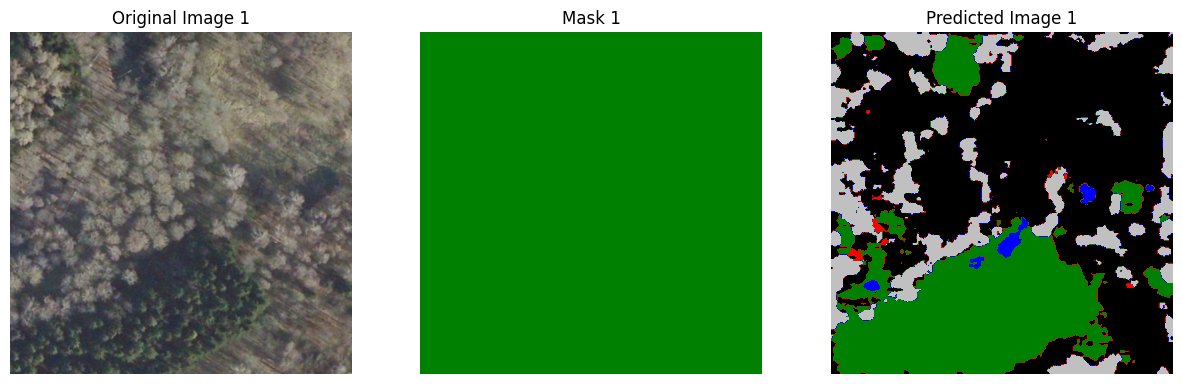

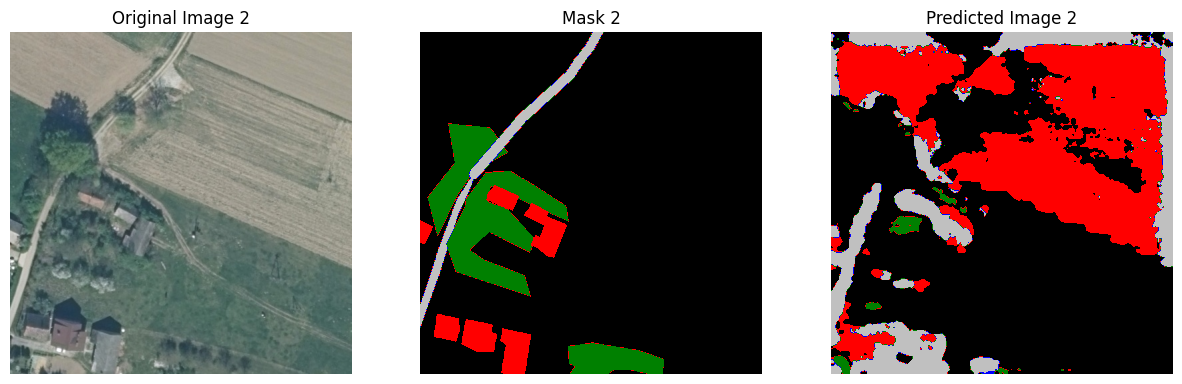

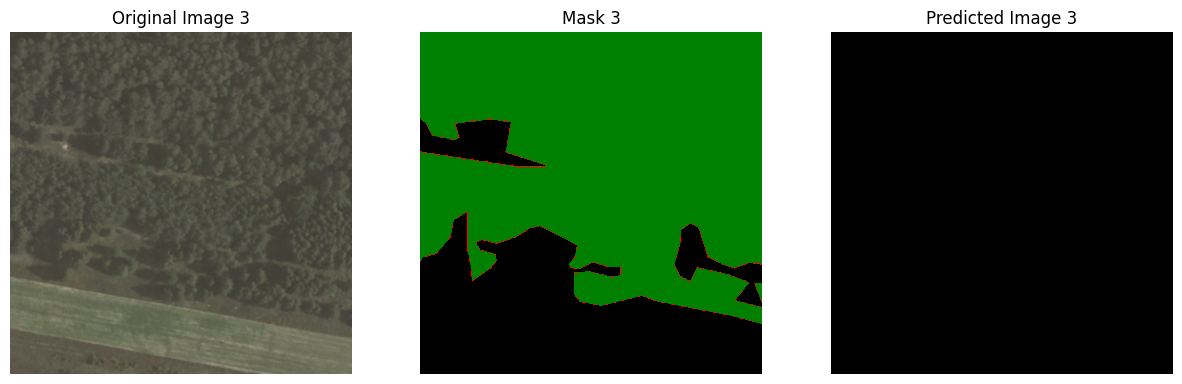

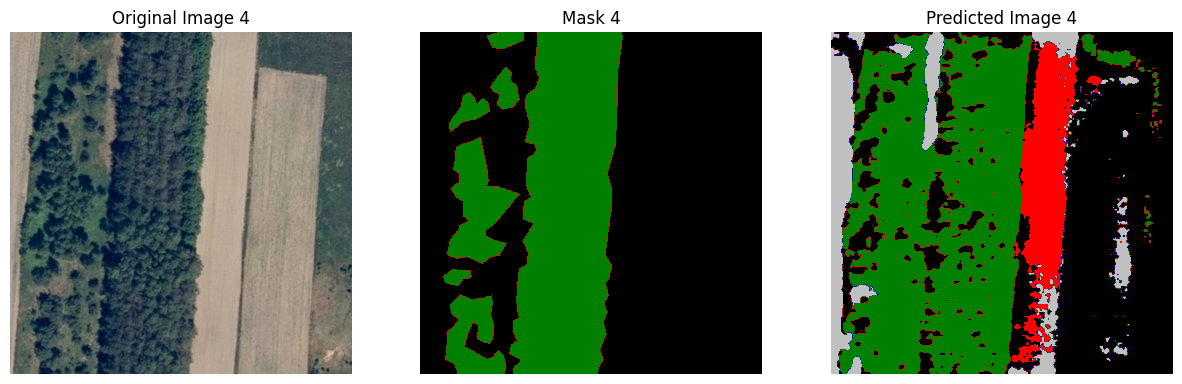

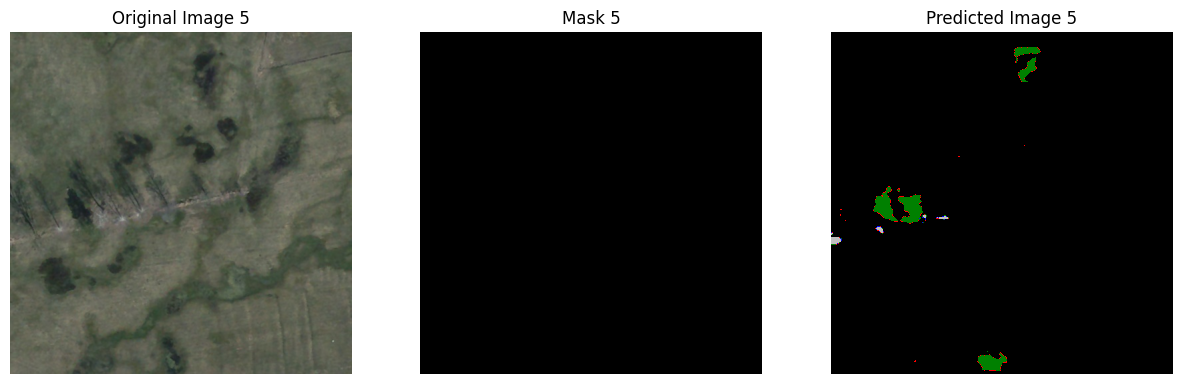

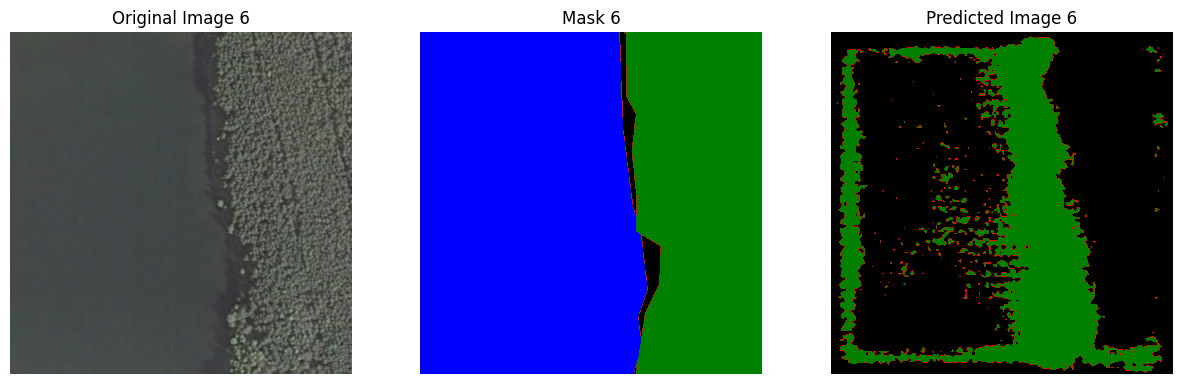

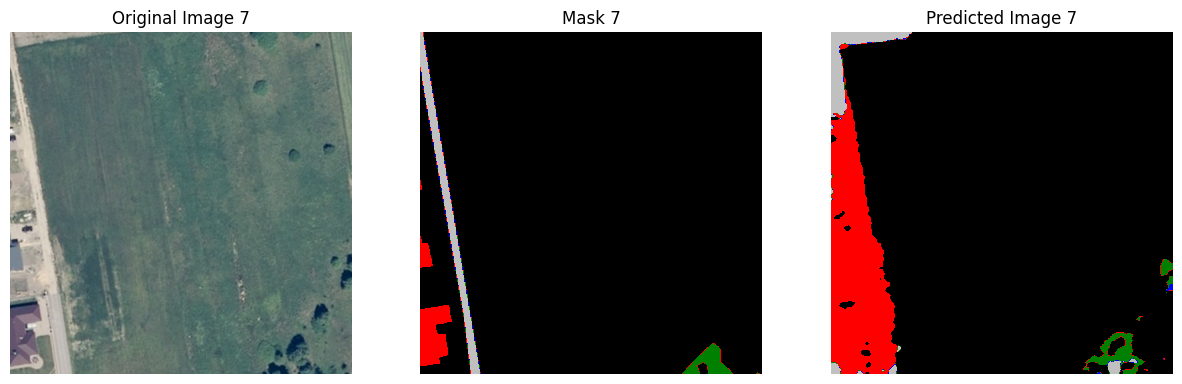

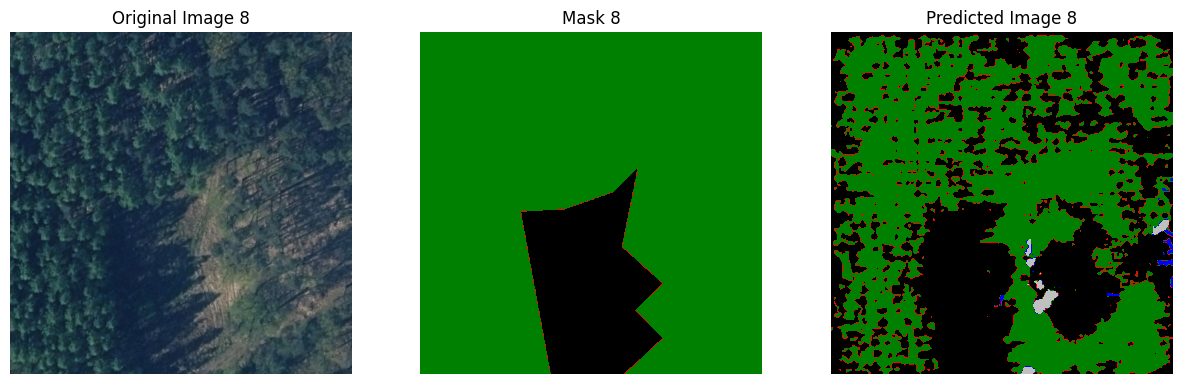

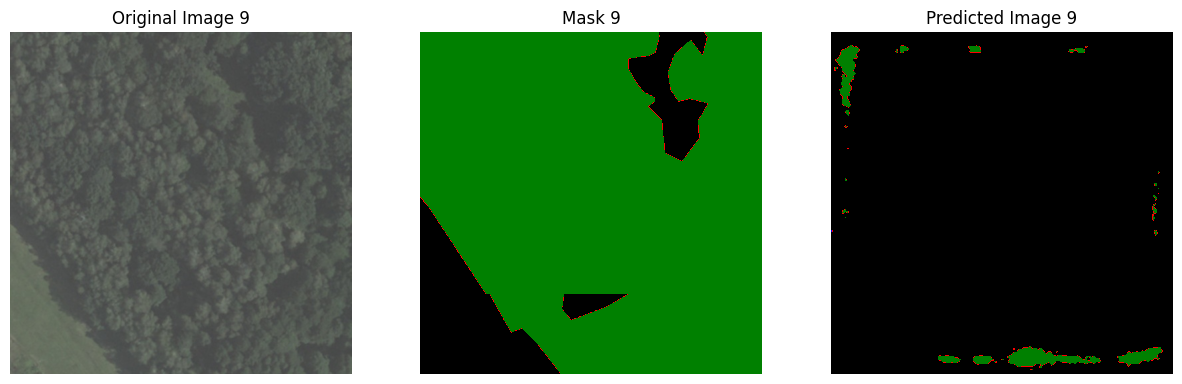

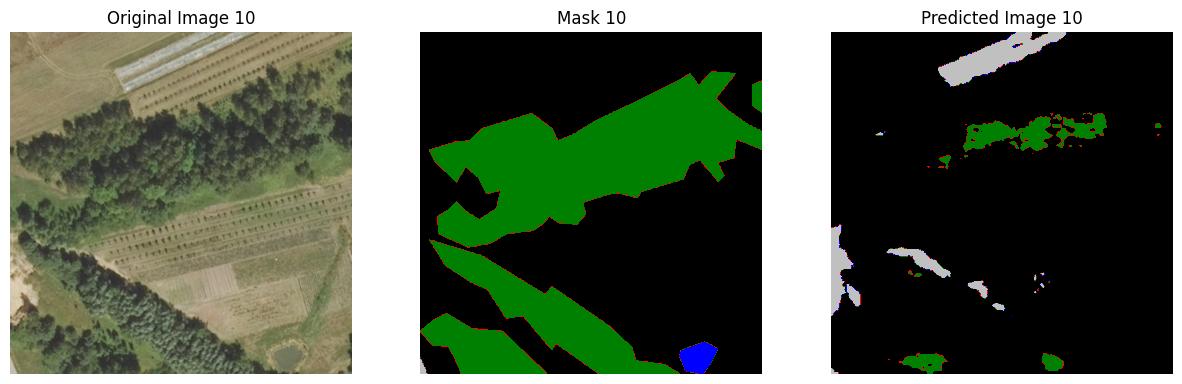

In [21]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

for i in range(10):
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow((selected_images['image'][i].permute(1, 2, 0)) / 255.0)
    plt.axis('off')
    plt.title(f'Original Image {i+1}')
    
    plt.subplot(1, 3, 2)
    plt.imshow(selected_images['mask'][i], cmap=ListedColormap(['black', 'red', 'green', 'blue', 'silver']), vmin=0, vmax=4)
    plt.axis('off')
    plt.title(f'Mask {i+1}')
    
    plt.subplot(1, 3, 3)
    plt.imshow(pred_tensor[i], cmap=ListedColormap(['black', 'red', 'green', 'blue', 'silver']), vmin=0, vmax=4)
    plt.axis('off')
    plt.title(f'Predicted Image {i+1}')
    
    plt.show()


In [12]:
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import random

# Custom Dataset to load .jpg images and their corresponding _m.png masks
class JPGWithMaskDataset(Dataset):
    def __init__(self, folder_path, transform=None, limit=10):
        self.folder_path = folder_path
        self.transform = transform
        
        # List all .jpg files in the folder
        self.jpg_files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]
        
        # Randomly select up to 10 .jpg files
        self.jpg_files = random.sample(self.jpg_files, min(len(self.jpg_files), limit))

    def __len__(self):
        return len(self.jpg_files)

    def __getitem__(self, idx):
        # Get the image and mask filenames
        img_name = self.jpg_files[idx]
        mask_name = img_name.replace('.jpg', '_m.png')
        
        # Load the image and mask
        img_path = os.path.join(self.folder_path, img_name)
        mask_path = os.path.join(self.folder_path, mask_name)
        
        image = Image.open(img_path).convert("RGB")  # Convert the image to RGB
        mask = Image.open(mask_path).convert("L")  # Convert the mask to grayscale
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)  # You can use a different transform for masks if needed
        
        return image, mask, img_name  # Return the image, mask, and image filename

# Define transformations for the images
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to fixed size (optional)
    transforms.ToTensor()           # Convert image/mask to tensor
])

# Path to your folder containing images and masks
image_folder_path = 'data/landcoverai/output/'

# Create the dataset (limit to 10 .jpg files)
jpg_dataset = JPGWithMaskDataset(folder_path=image_folder_path, transform=transform, limit=10)

# Create the DataLoader
batch_size = 5  # Set batch size as needed
dataloader = DataLoader(jpg_dataset, batch_size=batch_size, shuffle=True)

# Example: Iterate over the DataLoader and get a batch
for batch in dataloader:
    images, masks, filenames = batch
    print(f"Batch of images: {images.shape}")
    print(f"Batch of masks: {masks.shape}")
    print(f"Filenames: {filenames}")


Batch of images: torch.Size([5, 3, 256, 256])
Batch of masks: torch.Size([5, 1, 256, 256])
Filenames: ('N-33-139-D-c-1-3_310.jpg', 'N-34-140-A-d-3-4_174.jpg', 'M-34-65-D-d-4-1_5.jpg', 'M-34-65-D-c-4-2_122.jpg', 'M-34-65-D-a-4-4_88.jpg')
Batch of images: torch.Size([5, 3, 256, 256])
Batch of masks: torch.Size([5, 1, 256, 256])
Filenames: ('N-33-130-A-d-3-3_173.jpg', 'N-33-139-D-c-1-3_219.jpg', 'M-34-32-B-a-4-3_245.jpg', 'M-34-68-B-a-1-3_231.jpg', 'M-33-20-D-c-4-2_83.jpg')


In [22]:
import numpy as np
import os
from PIL import Image

output_folder = './predicted_masks/'
os.makedirs(output_folder, exist_ok=True)

for batch in dataloader:
    images, masks, filenames = batch
    selected_images = {'image': images, 'mask': masks, 'filename': filenames}
    predictions = loaded_model.predict_step(selected_images, 0)
    pred_tensor, filenames = predictions 
    
    for i, filename in enumerate(filenames):
        pred_mask = pred_tensor[i].cpu().numpy()
        pred_mask_scaled = (pred_mask * 255).astype(np.uint8)
        pred_mask_filename = os.path.join(output_folder, filename.replace('.jpg', '_pred.png'))
        Image.fromarray(pred_mask_scaled).save(pred_mask_filename)
        print(f"Saved predicted mask: {pred_mask_filename}")

Saved predicted mask: ./predicted_masks/N-33-139-D-c-1-3_310_pred.png
Saved predicted mask: ./predicted_masks/M-33-20-D-c-4-2_83_pred.png
Saved predicted mask: ./predicted_masks/N-33-139-D-c-1-3_219_pred.png
Saved predicted mask: ./predicted_masks/M-34-68-B-a-1-3_231_pred.png
Saved predicted mask: ./predicted_masks/N-34-140-A-d-3-4_174_pred.png
Saved predicted mask: ./predicted_masks/M-34-65-D-a-4-4_88_pred.png
Saved predicted mask: ./predicted_masks/N-33-130-A-d-3-3_173_pred.png
Saved predicted mask: ./predicted_masks/M-34-65-D-d-4-1_5_pred.png
Saved predicted mask: ./predicted_masks/M-34-65-D-c-4-2_122_pred.png
Saved predicted mask: ./predicted_masks/M-34-32-B-a-4-3_245_pred.png
